# Arrival Rate vs Latency Analysis

This notebook analyzes the relationship between arrival rate and average latency in the MBPP testing results.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# CSV path
csv_path = "../logs/mbpp_2026-01-25-02-05-08_telemetry.csv"

In [10]:
# Load the data
df = pd.read_csv(csv_path)

# Display basic information
print(f"Total rows: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Total rows: 1162

Columns: ['run_id', 'dataset', 'split', 'batch_id', 'item_id', 'record_type', 'task_name', 'reasoning_name', 'decision_method', 'graph_id', 'num_rounds', 'num_agents', 'agent_roles_json', 'agent_llms_json', 'role_llm_map_json', 'workflow_latency_seconds', 'llm_elapsed_seconds', 'node_id', 'node_name', 'role_name', 'llm_name', 'is_decision_node', 'round_idx', 'attempts', 'success', 'error', 'ts_start', 'ts_end', 'duration_sec', 'cost_delta', 'prompt_tokens', 'completion_tokens', 'total_tokens', 'output_text', 'router_log_prob', 'router_task_probs_json', 'router_agent_num_pred', 'utility', 'quality_is_correct', 'quality_pred', 'quality_gold', 'quality_feedback', 'quality_state_json', 'eval_duration_sec', 'arrival_rate', 'arrival_pattern']

First few rows:


,run_id,dataset,split,batch_id,item_id,record_type,task_name,reasoning_name,decision_method,graph_id,...,router_agent_num_pred,utility,quality_is_correct,quality_pred,quality_gold,quality_feedback,quality_state_json,eval_duration_sec,arrival_rate,arrival_pattern
0,2026-01-25-02-05-08,mbpp,test,0.0,17,workflow,Code,Reflection,FinalRefer,j6L6,...,4.396433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2026-01-25-02-05-08,mbpp,test,0.0,17,node,Code,Reflection,FinalRefer,j6L6,...,4.396433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2026-01-25-02-05-08,mbpp,test,0.0,17,node,Code,Reflection,FinalRefer,j6L6,...,4.396433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2026-01-25-02-05-08,mbpp,test,0.0,17,node,Code,Reflection,FinalRefer,j6L6,...,4.396433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2026-01-25-02-05-08,mbpp,test,0.0,17,node,Code,Reflection,FinalRefer,j6L6,...,4.396433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Filter for quality records only (these contain the arrival_rate and workflow metrics)
quality_df = df[df['record_type'] == 'quality'].copy()

print(f"Quality records: {len(quality_df)}")
print(f"\nArrival rates in data: {quality_df['arrival_rate'].unique()}")
print(f"\nArrival pattern: {quality_df['arrival_pattern'].unique()}")

Quality records: 150

Arrival rates in data: [ 5. 15. 20.]

Arrival pattern: ['poisson']


In [12]:
# Calculate average and p95 latency per arrival rate
latency_by_rate = quality_df.groupby('arrival_rate')['workflow_latency_seconds'].agg(
    mean='mean',
    std='std',
    p95=lambda x: x.quantile(0.95),
    count='count'
).reset_index()

print("Latency statistics by arrival rate:")
print(latency_by_rate)

Latency statistics by arrival rate:
   arrival_rate       mean        std        p95  count
0           5.0  16.511492  12.583752  35.423556     50
1          15.0  13.236605  11.622491  31.601330     50
2          20.0  16.202976  10.619815  30.438619     50


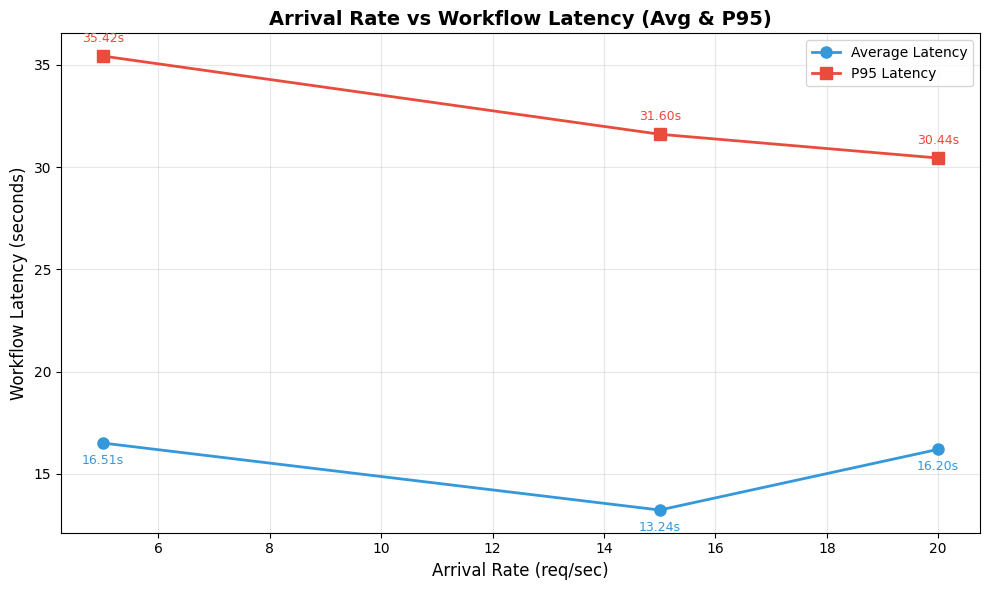

In [13]:
# Create the plot with average and p95 latency
plt.figure(figsize=(10, 6))

# Plot average latency
plt.plot(latency_by_rate['arrival_rate'], 
         latency_by_rate['mean'],
         marker='o', 
         markersize=8,
         linewidth=2,
         color='#3498db',
         label='Average Latency')

# Plot p95 latency
plt.plot(latency_by_rate['arrival_rate'], 
         latency_by_rate['p95'],
         marker='s', 
         markersize=8,
         linewidth=2,
         color='#e74c3c',
         label='P95 Latency')

plt.xlabel('Arrival Rate (req/sec)', fontsize=12)
plt.ylabel('Workflow Latency (seconds)', fontsize=12)
plt.title('Arrival Rate vs Workflow Latency (Avg & P95)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Add value labels on the points
for idx, row in latency_by_rate.iterrows():
    plt.annotate(f"{row['mean']:.2f}s", 
                 (row['arrival_rate'], row['mean']),
                 textcoords="offset points",
                 xytext=(0, -15),
                 ha='center',
                 fontsize=9,
                 color='#3498db')
    plt.annotate(f"{row['p95']:.2f}s", 
                 (row['arrival_rate'], row['p95']),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center',
                 fontsize=9,
                 color='#e74c3c')

plt.tight_layout()
plt.show()

In [14]:
# Calculate throughput (requests per second) for each arrival rate
# Throughput based on average and p95 latency
throughput_by_rate = quality_df.groupby('arrival_rate')['workflow_latency_seconds'].agg(
    avg_latency='mean',
    p95_latency=lambda x: x.quantile(0.95),
    count='count'
).reset_index()

# Throughput as inverse of latency
throughput_by_rate['throughput_avg'] = 1 / throughput_by_rate['avg_latency']
throughput_by_rate['throughput_p95'] = 1 / throughput_by_rate['p95_latency']

print("Throughput by arrival rate:")
print(throughput_by_rate[['arrival_rate', 'avg_latency', 'p95_latency', 'throughput_avg', 'throughput_p95']])

Throughput by arrival rate:
   arrival_rate  avg_latency  p95_latency  throughput_avg  throughput_p95
0           5.0    16.511492    35.423556        0.060564        0.028230
1          15.0    13.236605    31.601330        0.075548        0.031644
2          20.0    16.202976    30.438619        0.061717        0.032853


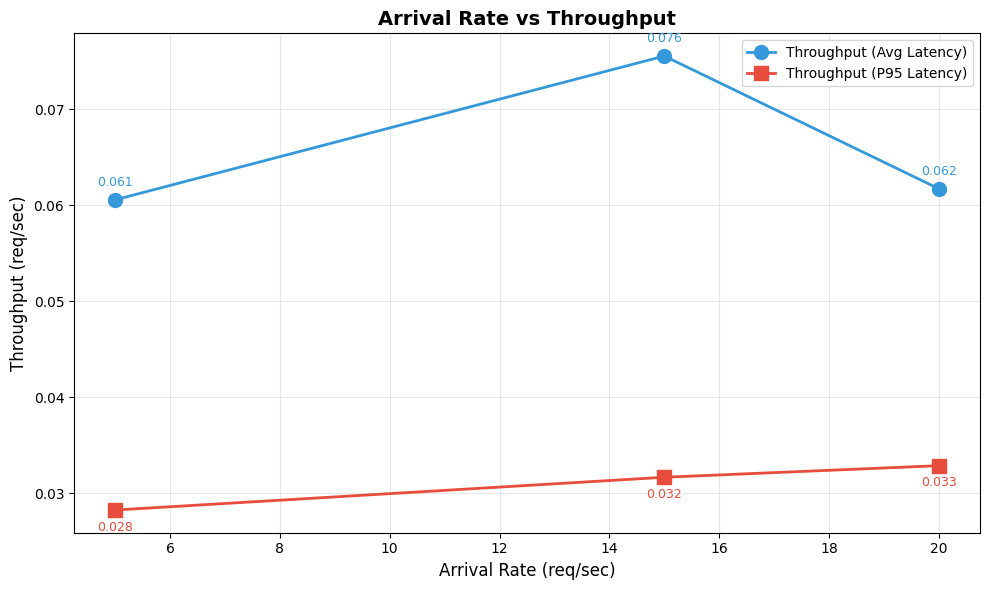

In [15]:
# Plot: Arrival Rate vs Throughput (Avg and P95-based)
plt.figure(figsize=(10, 6))

# Throughput based on average latency
plt.plot(throughput_by_rate['arrival_rate'], 
         throughput_by_rate['throughput_avg'],
         marker='o', 
         markersize=10,
         linewidth=2,
         color='#3498db',
         label='Throughput (Avg Latency)')

# Throughput based on p95 latency
plt.plot(throughput_by_rate['arrival_rate'], 
         throughput_by_rate['throughput_p95'],
         marker='s', 
         markersize=10,
         linewidth=2,
         color='#e74c3c',
         label='Throughput (P95 Latency)')

plt.xlabel('Arrival Rate (req/sec)', fontsize=12)
plt.ylabel('Throughput (req/sec)', fontsize=12)
plt.title('Arrival Rate vs Throughput', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Add value labels
for idx, row in throughput_by_rate.iterrows():
    plt.annotate(f"{row['throughput_avg']:.3f}", 
                 (row['arrival_rate'], row['throughput_avg']),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center',
                 fontsize=9,
                 color='#3498db')
    plt.annotate(f"{row['throughput_p95']:.3f}", 
                 (row['arrival_rate'], row['throughput_p95']),
                 textcoords="offset points",
                 xytext=(0, -15),
                 ha='center',
                 fontsize=9,
                 color='#e74c3c')

plt.tight_layout()
plt.show()